In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpu_devices = tf.config.list_physical_devices('GPU')
for device in gpu_devices:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

2023-12-22 19:38:08.207447: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-22 19:38:08.245795: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-22 19:38:08.245819: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-22 19:38:08.246742: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-22 19:38:08.252774: I tensorflow/core/platform/cpu_feature_guar

Num GPUs Available:  1
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import pandas as pd
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from Threshold import get_threshold

#MODEL_T = "models/lstm_technical_eurusd.h5"
#MODEL_F = "models/fundamental_model_eurusd_300epochs.h5"

MODEL_T = "./models/prob_model.keras"
MODEL_F = "./models/fundamental_model_eurusd_300epochs.keras"

# data is concatenated, need to separate into technical and fundamental datasets
DATA = 'data/technical+fundamental_data_eurusd.csv'

dataframe = read_csv(DATA, engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

In [3]:
# cut off first 20 values
dataset = dataset[20:]
dataset = dataset[:, 1:]

# normalize the dataset 
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into two
dataset_t = dataset[:,:9]
dataset_f = dataset[:,[0,9,10,11,12,13,14,15]]

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def train_test_split(dataset):
    n_cols = dataset.shape[1]

    train_size = int(len(dataset) * 0.8)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

    # convert an array of values into a dataset matrix

    look_back = 5
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], look_back, n_cols))
    testX = np.reshape(testX, (testX.shape[0], look_back, n_cols))

    return trainX, testX, testY

_, t_testX, testY = train_test_split(dataset_t)
_, f_testX, _ = train_test_split(dataset_f)

model_t = tf.keras.models.load_model(MODEL_T)
model_f = tf.keras.models.load_model(MODEL_F)
print(t_testX[0:5])
print(t_testX.shape)


2023-12-22 19:38:10.333890: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 398 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:00:0d.0, compute capability: 8.0
2023-12-22 19:38:10.405592: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


[[[0.49307704 0.47204375 0.5363327  0.37815517 0.48376656 0.49418122
   0.49042606 0.4873321  0.44778994]
  [0.49929738 0.4744897  0.5436644  0.49361697 0.54172146 0.5418774
   0.48972416 0.4870398  0.4477688 ]
  [0.4987905  0.4766085  0.5493674  0.44920188 0.47193283 0.53767693
   0.48734975 0.48725724 0.45766506]
  [0.5141337  0.48138642 0.56723213 0.5536479  0.58895516 0.64903027
   0.48584223 0.48775363 0.54564106]
  [0.51118493 0.48494983 0.57883966 0.43321863 0.54870033 0.6211824
   0.4835186  0.48872232 0.5627965 ]]

 [[0.49929738 0.4744897  0.5436644  0.49361697 0.54172146 0.5418774
   0.48972416 0.4870398  0.4477688 ]
  [0.4987905  0.4766085  0.5493674  0.44920188 0.47193283 0.53767693
   0.48734975 0.48725724 0.45766506]
  [0.5141337  0.48138642 0.56723213 0.5536479  0.58895516 0.64903027
   0.48584223 0.48775363 0.54564106]
  [0.51118493 0.48494983 0.57883966 0.43321863 0.54870033 0.6211824
   0.4835186  0.48872232 0.5627965 ]
  [0.49551916 0.48498368 0.57457614 0.3497792  0

In [4]:
# Inverse scale the data
def inverse_transform(arr):
    num_cols_full_dataset = 16
    extended = np.zeros((len(arr), num_cols_full_dataset))
    extended[:, 0] = arr
    return scaler.inverse_transform(extended)[:, 0]

def decision(diff):
    if diff > threshold:
        return "I"
    if -diff > threshold:
        return "D"
    else:
        return "N"

def union(a, b):
    if a == "I" and b == "I":
        return "C"
    if a == "D" and b == "D":
        return "C"
    if a == "N" or b == "N":
        return "N"
    else:
        return "F"
    
def combination(t_decision, f_decision, t_diff, f_diff, t_loss, f_loss):
    if t_decision == "N" or f_decision == "N":
        return "N"
    if t_decision == f_decision:
        return t_decision
    else:
        # # if conflict, return lowest change
        # if abs(t_diff) > abs(f_diff):
        #     return f_decision
        # else: 
        #     return t_decision
        
        # if conflict, return lowest loss in previous step
        if np.isnan(t_loss) or np.isnan(f_loss):
            return t_decision
        if abs(t_loss) == abs(f_loss):
            return t_decision
        else:
            if abs(t_loss) < abs(f_loss):
                return t_decision
            else:
                return f_decision

testPredict_t = model_t.predict(t_testX)
testPredict_t = np.squeeze(testPredict_t)

testPredict_f = model_f.predict(f_testX)
testPredict_f = np.squeeze(testPredict_f)

testPredict_t = inverse_transform(testPredict_t)
testPredict_f = inverse_transform(testPredict_f)
print("testPredict shape", testPredict_f.shape)

testY = inverse_transform(testY)

# threshold and make decisions
threshold = get_threshold(dataframe["Close"]) * 3

18/18 [==============================] - 0s 2ms/step


2023-12-22 19:38:11.354861: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


18/18 [==============================] - 0s 1ms/step
testPredict shape (563,)


In [5]:
table = pd.DataFrame([testY, testPredict_t, testPredict_f]).transpose()
table.columns = ["actual", "technical", "fundamental"]
table["t decision"] = (table.technical - table.actual).apply(decision)
table["f decision"] = (table.fundamental - table.actual).apply(decision)
table["correct"] = table["actual"].diff(
).shift(-1).apply(lambda x: "I" if x > 0 else "D" if x < 0 else "N")
table["t union"] = table.apply(lambda x: union(
    x["t decision"], x["correct"]), axis=1)
table["f union"] = table.apply(lambda x: union(
    x["f decision"], x["correct"]), axis=1)
table["t loss"] = table.technical.shift(1) - table.actual
table["f loss"] = table.fundamental.shift(1) - table.actual
table["t diff"] = table.technical - table.actual
table["f diff"] = table.fundamental - table.actual
table["combination"]  = table.apply(lambda x: combination(
    x["t decision"], x["f decision"], x["t diff"], x["f diff"], x["t loss"], x["f loss"]), axis=1)

table["union"] = table.apply(lambda x: union(
    x["combination"], x["correct"]), axis=1)

print(table)

      actual  technical  fundamental t decision f decision correct t union  \
0    1.17440   1.180364     1.175430          N          N       I       N   
1    1.17452   1.173231     1.168663          N          N       D       N   
2    1.17073   1.173017     1.169317          N          N       I       N   
3    1.17132   1.169923     1.165585          N          N       I       N   
4    1.17695   1.169896     1.166185          D          D       I       F   
..       ...        ...          ...        ...        ...     ...     ...   
558  1.05325   1.059434     1.041729          I          D       D       F   
559  1.04877   1.058887     1.043470          I          N       D       F   
560  1.04629   1.054300     1.038943          I          D       I       C   
561  1.05029   1.053479     1.035812          N          D       I       N   
562  1.05540   1.058134     1.037738          N          D       N       N   

    f union    t loss    f loss    t diff    f diff combination

In [6]:
counts = table["union"].value_counts()
frequency = table["union"].value_counts(normalize=True)
print(pd.DataFrame({"counts": counts, "frequency": frequency}))

       counts  frequency
union                   
N         450   0.799290
F          60   0.106572
C          53   0.094139


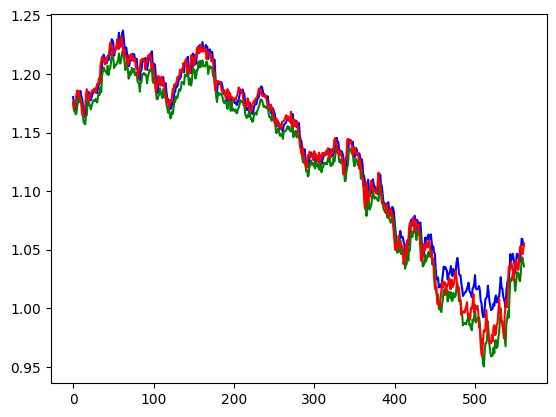

In [7]:
# shift predictions up by one
testPredict_t = np.delete(testPredict_t, -1)
testPredict_f = np.delete(testPredict_f, -1)
testY = np.delete(testY, 0)

# Plot results
plt.plot(testPredict_t, color="blue")
plt.plot(testPredict_f, color="green")
plt.plot(testY, color="red")
plt.savefig("tmp/ti-me-lstm.png")
plt.show()